# Milestone 3

1. Write a function that computes a 6-parameter geometric registration (global scale x, global scale y, rotation, and translations along two axes and sheering) between two mid-coronal MRI slices from two different subjects (a fixed image and a moving image). This step will consist of following sub-steps.

    – a function that takes in an input (moving) image, 4 transformation parameters (global scale, rotation, and translations along two axes) and output (fixed image) grid size, and computes the output (moved) image. The output image has a size of the output grid size and pixel values are obtained by resampling the input image onto the output grid via applying the geometric transformation: a global scale multiplied with a rotation matrix, followed by a translation. Outside-of-grid-range values can default to zero.
    
    – a loss function that takes three inputs: a length-4 vector of geometric transformation parameters, a fixed image, and a moving image. The output should be equal to the sum of squared differences between the geometrically transformed moved image and the fixed image.
    
    – an optimization module that minimizes the loss function for a given input image pair (fixed and moving). This module should return two things: the transformed moving image and the optimal geometric transformation parameters.

In [10]:
import pickle
import numpy as np
from PIL import Image
import nibabel as nib
from scipy import ndimage
from scipy.stats import mode
from scipy.optimize import fmin, fmin_cg, fmin_powell, fmin_bfgs, fmin_ncg
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
%matplotlib inline

def transformFunc(inpImg, transVector, shape, method='linear'):
    """
    Returns the geometrically transformed image of the inpImg. 
    
    Param:
        inpImg : array type 
        shape  : (y,x)-tuple of output shape
        transVector : [ sx, sy, sh, rad, tx, ty]
            - sx : x-scale factor 
            - sy : y-scale factor
            - sh : sheer factor in rad
            - rad: rotation factor in rad
            - tx : shift in the x-direction
            - ty : shift in the y direction
    """
    [sx, sy, sh, rad, tx, ty] = transVector
    b = np.linspace(-256//2, 256//2, 256)
    bb, aa = np.array(np.meshgrid(b,b))
    R = np.array([[np.cos(rad), -np.sin(rad)],
                  [np.sin(rad), np.cos(rad)]])

    #Transform the coordinates
    c_1 = (1/sy)*R[0,0]*aa + R[0,1]*bb*np.tan(sh)
    c_2 = R[1,0]*aa + (1/sx)*R[1,1]*bb
    b_orig = np.linspace(-128, 128, 256)
    f = RegularGridInterpolator((b_orig, b_orig), inpImg, 
            bounds_error=False, fill_value=0, method=method)
    return f(np.stack((c_1+tx, c_2+ty), axis=2))


def lossFunc(transVector, movingImg, fixedImg):
    """
    Returns the sum of squared differences between the geometrically transformed and the fixed image. 
    
    Param:
        movingImg : array type 
        fixedImg  : array type
        transVector : 6-parameter vector
    """
    transImg = transformFunc(movingImg, transVector, fixedImg.shape)
    diff = np.subtract(fixedImg, transImg)
    diff_square = np.square(diff)
    diff_square_sum = np.sum(diff_square)
    return diff_square_sum


def optimize(movingImg, fixedImg, initial=[1, 1, np.pi/4, 0, 0, 0]):
    """
    Returns the optimally translated image and the optimization parameters. 
    
    Param:
        moving : array type 
        fixed  : array type
        initial: 6-parameter vector
    """
    params = fmin_cg(lossFunc, initial, args=(movingImg, fixedImg),
                    maxiter = 10000, full_output=0, disp=0)
    optimizedImg = transformFunc(movingImg, params, fixedImg.shape)
    return optimizedImg, params

2.  Use  your  registration  tool  to  resample  each  training  image  (moving)  onto  eachvalidation image (fixed) (i.e., you need to run 12 registration instances).  

3. Apply the registration results (optimal transformations) to resample the manual segmentations of each training subject onto the validation subject grids (use nearest neighbor interpolation).

In [6]:
# load the original data
cases = pickle.load( open( "cases.pkl", "rb" ) )

# split the data into two groups
validationCases = {}
trainingCases = {}
for case in cases:
    if case["type"] == 'Validation':
        if case["name"][:7] not in validationCases:
            validationCases[case["name"][:7]] = []
        validationCases[case["name"][:7]].append(case)
    elif case["type"] == 'Training':
        if case["name"][:7] not in trainingCases:
            trainingCases[case["name"][:7]] = []
        trainingCases[case["name"][:7]].append(case)

# optimize images and add to main data structure
masterDict = {}
coronal_slice_idx = 63
for vCName, validationCase in validationCases.items():
    fixedUnseg = validationCase[0]['slice']
    fixedSeg = validationCase[1]['slice']
    masterDict[vCName] = {  'name' : vCName,
                            'fixedSeg' : fixedSeg,
                            'fixedUnseg' : fixedUnseg,
                            'mappings': [] }
    
    for tCName, trainingCase in trainingCases.items():
        movingUnseg = trainingCase[0]['slice']
        movingSeg = trainingCase[1]['slice']
        
        optimizedUnseg, params = optimize(movingUnseg/np.max(movingUnseg)*255, fixedUnseg/np.max(fixedUnseg)*255)
        optimizedSeg = transformFunc(movingSeg, params, fixedSeg.shape, method="nearest")
        
        mapping = { "name" : tCName,
                    'params' : params,
                    'movingSeg':movingSeg,
                    'optimizedSeg':optimizedSeg,
                    'movingUnseg':movingUnseg,
                    'optimizedUnseg':optimizedUnseg }
        masterDict[vCName]['mappings'].append(mapping)
        
        print(tCName+'-->'+vCName+"\n", params) # print the progress

IBSR_05-->IBSR_15
 [ 1.00065868  1.08327258  0.40197088  0.00950842 -0.39119943  0.1131265 ]
IBSR_02-->IBSR_15
 [ 0.97173664  1.0306429   0.68844786 -0.00871449 -0.29701526 -0.06188641]
IBSR_03-->IBSR_15
 [ 1.17562407e+00  1.06109896e+00  1.43279694e+00  9.42753269e-04
 -7.96721281e-01 -3.37900544e+00]
IBSR_04-->IBSR_15
 [ 1.19262650e+00  1.05536701e+00  6.43080425e-01 -1.61641543e-03
 -6.77714570e-01 -2.53683558e+00]
IBSR_01-->IBSR_15
 [1.08941878 1.02775683 0.69444656 0.0134567  0.11763109 0.08331759]
IBSR_06-->IBSR_15
 [ 1.00035979  1.07401335  1.3442139   0.01003064 -0.43868978 -0.01087515]
IBSR_05-->IBSR_07
 [ 9.45259353e-01  9.36582988e-01 -4.58895499e-01  4.96032627e-03
 -4.87447407e-01 -5.73627814e+00]
IBSR_02-->IBSR_07
 [ 8.78296126e-01  8.86267223e-01  7.42226629e-01 -9.49736606e-04
 -1.66838624e-01 -4.60236670e+00]
IBSR_03-->IBSR_07
 [ 1.01942003  0.92452458  0.03771623  0.0255582   0.85369415 -6.16878116]
IBSR_04-->IBSR_07
 [ 1.11190725e+00  9.66155667e-01  7.78690032e-01 -

Visualizesome slices of these results.  You need to show that your registration works - i.e.,plot results for before the registration and after the registration.

<Figure size 432x288 with 0 Axes>

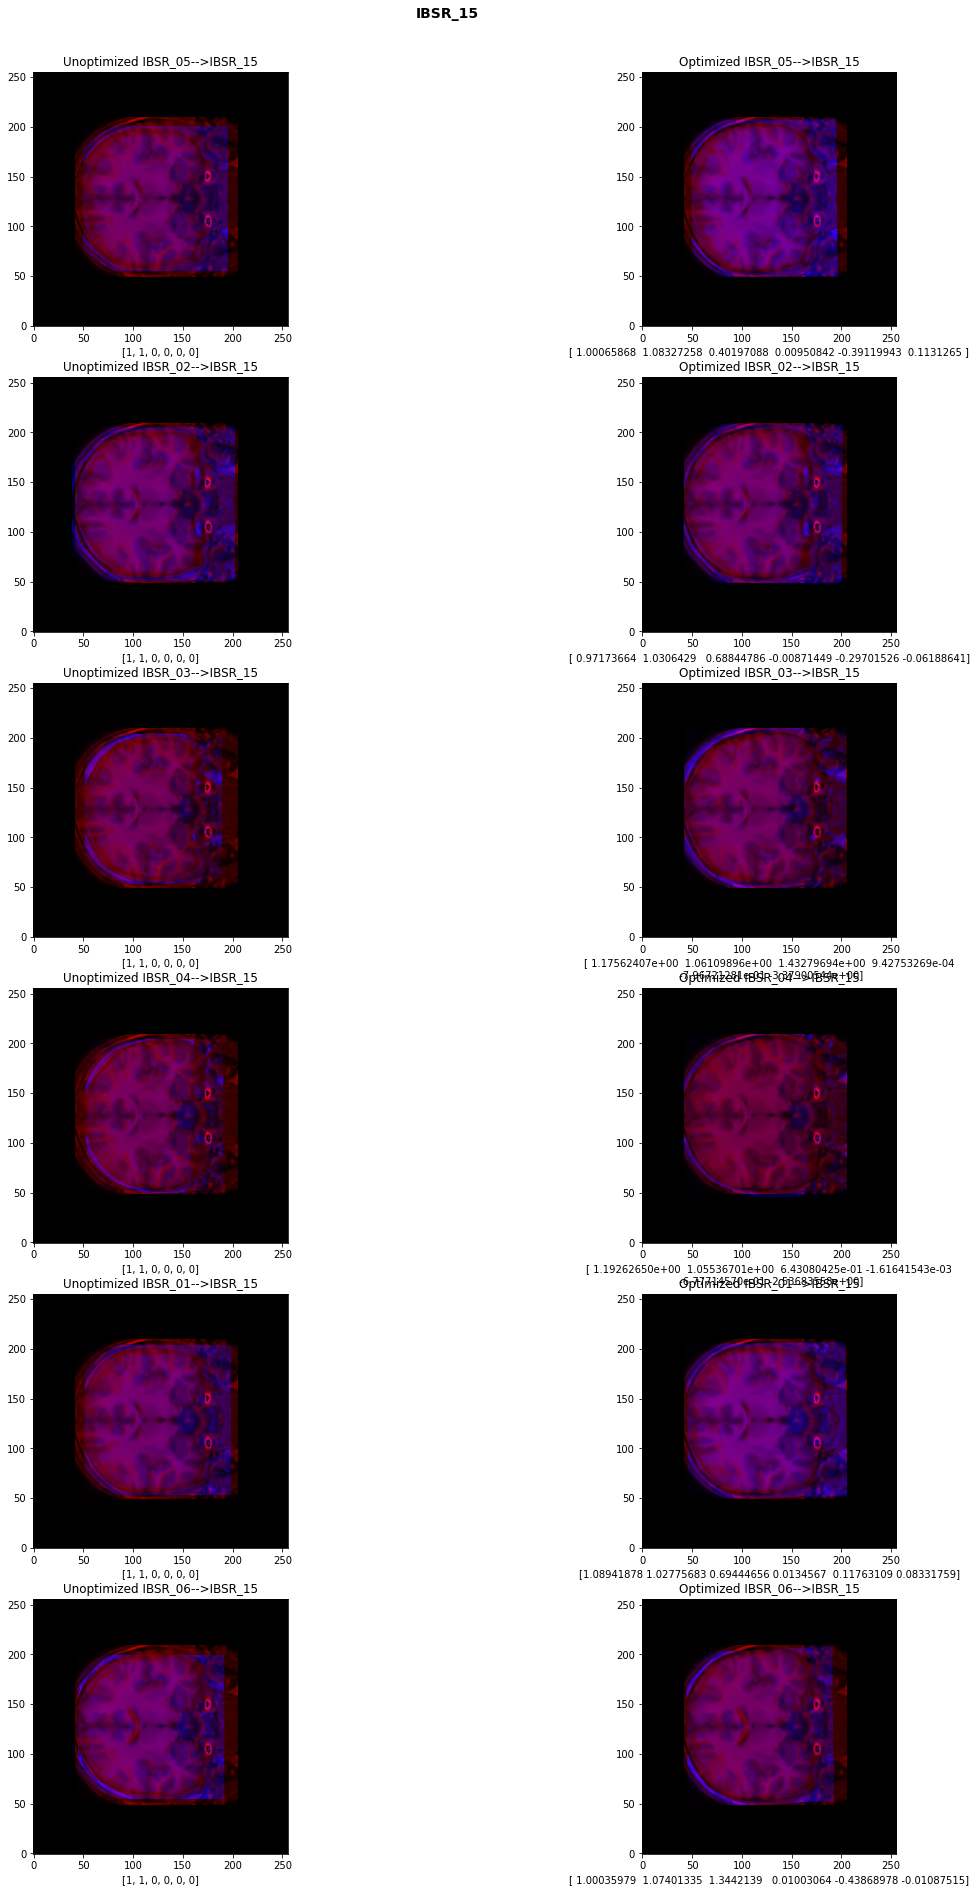

<Figure size 432x288 with 0 Axes>

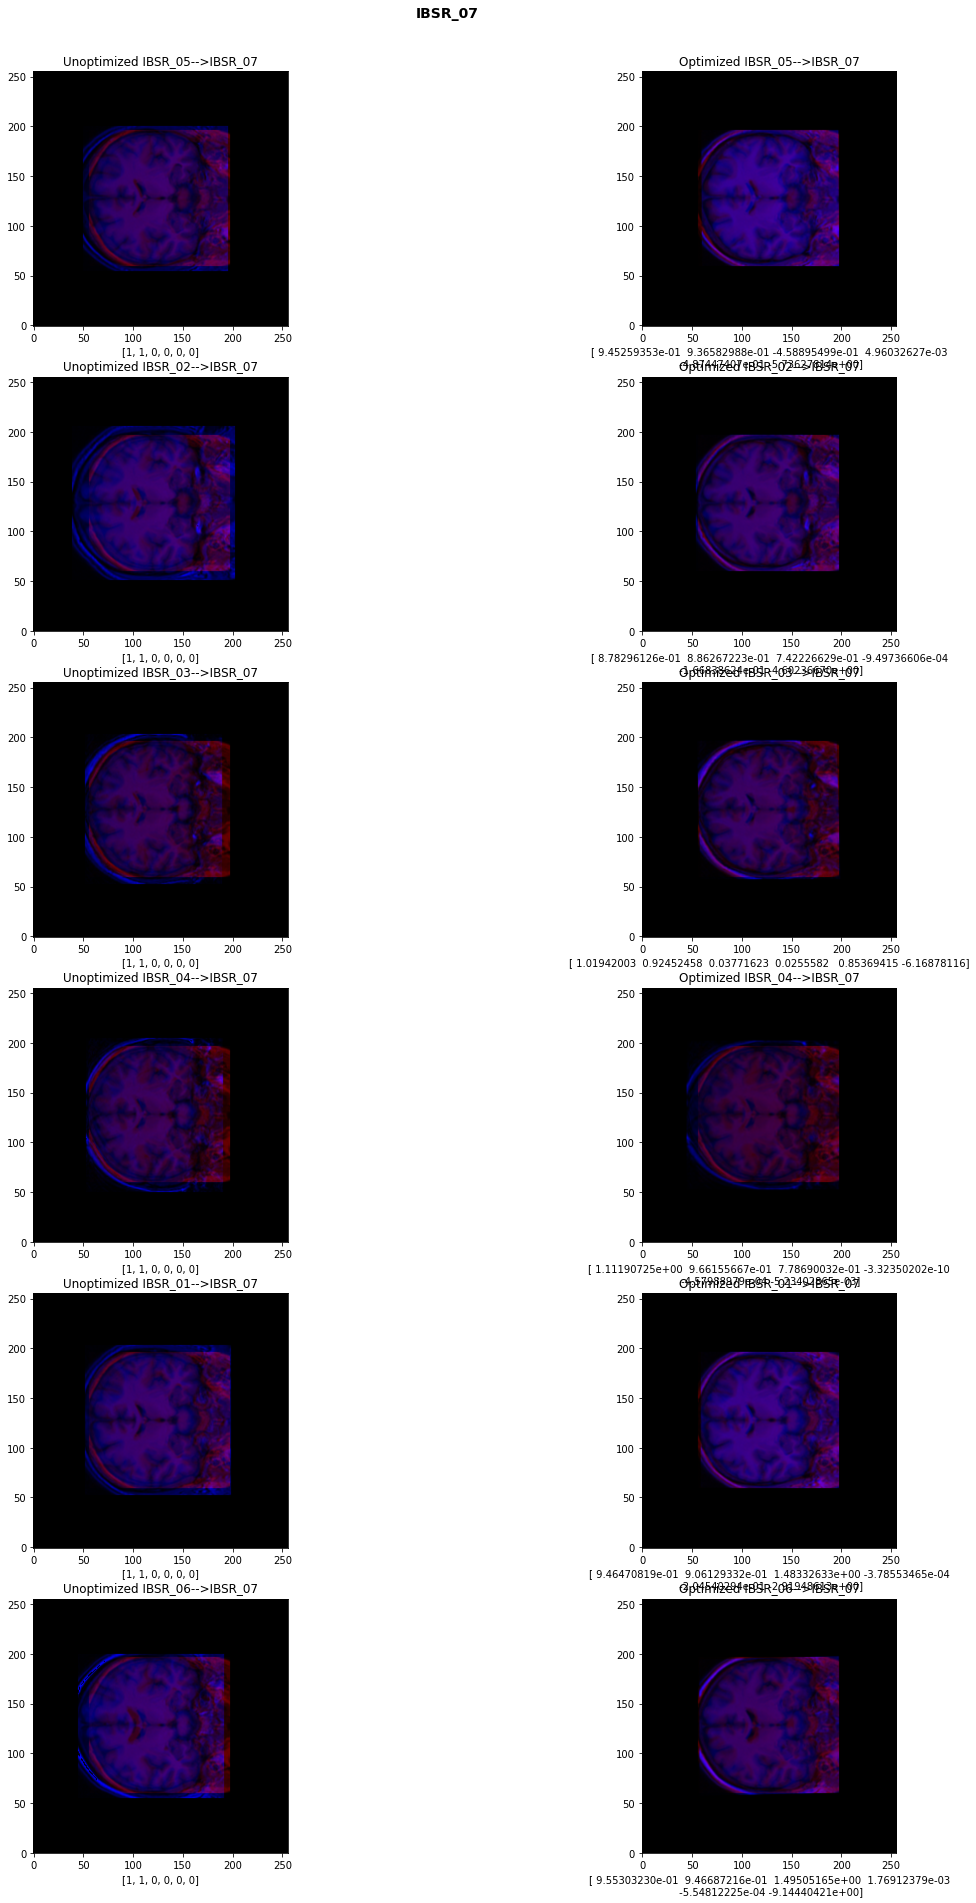

In [7]:
rgbArray = np.zeros((256,256,3), 'uint8')
for keyValidation, valueValidation in masterDict.items():  
    fig = plt.figure()
    fig, ax = plt.subplots(6, 2, figsize=(20,30), squeeze=False)
    fig.suptitle(keyValidation, fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.95)
    rgbArray[..., 0] = valueValidation['fixedUnseg']  # red
    
    for i, each in enumerate(valueValidation['mappings']):
        title = each['name']+'-->'+keyValidation
        
        rgbArray[..., 2] = each['movingUnseg']  # blue
        unsegmentedBefore = Image.fromarray(rgbArray)
        
        ax[i, 0].set_title('Unoptimized '+title)
        ax[i,0].imshow(unsegmentedBefore, origin="lower")
        ax[i,0].set_xlabel(str([1, 1, 0, 0, 0, 0]))
        
        rgbArray[..., 2] = each['optimizedUnseg']  # blue
        unsegmentedAfter = Image.fromarray(rgbArray)
        ax[i, 1].set_title('Optimized '+title)
        ax[i,1].imshow(unsegmentedAfter, origin="lower")
        ax[i,1].set_xlabel(str(each['params']))


4. For every pixel on validation subject grid, compute the most frequent training label – this is called majority voting based label fusion. You can implement any tie-break strategy you want. This is a crude segmentation of the validation subjects.

In [15]:
r = 10
for vname, vval in masterDict.items():
    imgLabel = np.zeros(vval['fixedUnseg'].shape)
    for y in range(r,256-(r+1)):
        for x in range(r,256-(r+1)):
            
            Tf = vval['fixedUnseg']
            Tfs = Tf[y-r:y+r+1, x-r:x+r+1]/np.max(Tf)*255
            lossVector = np.zeros(6)
            
            for i in range(len(vval['mappings'])):
                Afi = vval['mappings'][i]['optimizedUnseg']
                Afis = Afi[y-r:y+r+1, x-r:x+r+1]/np.max(Afi)*255
                lossVector[i] = np.sum(np.square(np.subtract(Tfs, Afis)))
                
            idx_of_similar_atlas = np.argmin(lossVector)
            label_from_atlas = vval['mappings'][idx_of_similar_atlas]['optimizedSeg'][y,x]
            imgLabel[y,x] = label_from_atlas

    masterDict[vname]["labeledSeg"] = imgLabel
    

5. Write a function that computes the Jaccard overlap index for a given region of interest (ROI) between an input manual segmentation and an automatic segmentation. The Jaccard index is defined as the ratio between the area of the intersection and the area of the union, where the intersection and union are defined with respect to the manual segmentation and an automatic segmentation.


6. Compute the Jaccard index for your automatic validation subject segmentations. Compile these in a table and print. Only consider following regions of interest (both left and right): Cerebral-White-Matter and Cerebral-Cortex.

        ROI = 2  --> Left-Cerebral-White-Matter      |  ROI = 41 --> Right-Cerebral-White-Matter  
        ROI = 3  --> Left-Cerebral-Cortex            |  ROI = 42 --> Right-Cerebral-Cortex 
    
      

In [16]:
def jaccard(manualSeg, autoSeg, roi):
    manSegROI = np.where(manualSeg == roi, 1, 0)
    autoSegROI = np.where(autoSeg == roi, 1, 0)
    unionROI = np.logical_or(manSegROI, autoSegROI)
    interROI = np.logical_and(manSegROI, autoSegROI)
    return np.sum(interROI)/np.sum(unionROI)

ROIS = {2:'Left-Cerebral-White-Matter', 3:'Left-Cerebral-Cortex',
       41:'Right-Cerebral-White-Matter', 42:'Right-Cerebral-Cortex'}

for key, value in masterDict.items():
    manualSeg = value['fixedSeg']
    autoSeg = value['labeledSeg']
    
    print("Validation: "+key)
    for k,v in ROIS.items():
        print(v, "\t\t jaccard=",jaccard(manualSeg, autoSeg, k))
    print("\n")

Validation: IBSR_15
Left-Cerebral-White-Matter 		 jaccard= 0.4889380530973451
Left-Cerebral-Cortex 		 jaccard= 0.4224119530416222
Right-Cerebral-White-Matter 		 jaccard= 0.5443108750349455
Right-Cerebral-Cortex 		 jaccard= 0.5161290322580645


Validation: IBSR_07
Left-Cerebral-White-Matter 		 jaccard= 0.5537392725786677
Left-Cerebral-Cortex 		 jaccard= 0.5529334644378893
Right-Cerebral-White-Matter 		 jaccard= 0.49350180505415164
Right-Cerebral-Cortex 		 jaccard= 0.4818828310193024


